## Testando Prompt (usando create_pandas_dataframe_agent)
Observações: aqui o prompt já é pre-made, portanto para alterar ele devo adicionar prefixo e/ou sufixo.

### Tokens e imports

In [5]:
# default
import os
from getpass import getpass
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict

# langchain 
from langgraph.graph.message import add_messages
from langchain.agents import tool
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description

from langchain_community.chat_models import ChatDeepInfra
from langchain_tavily import TavilySearch


from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.prompts import HumanMessagePromptTemplate

from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


from dotenv import load_dotenv
from pydantic import BaseModel


In [7]:
os.environ["DEEPINFRA_API_TOKEN"] = getpass("Digite sua chave da DeepInfra: ")

In [8]:
os.environ["TAVILY_API_KEY"] = getpass("Digite sua chave do Travily: ")
#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

### Definindo Tools
Aqui definirei as tools do meu agente. Estou responsável por colocar tools relacionadas a imputação de valores.
Irei colocar algumas opções e tentar explicar as características de cada uma, para que o agente decida qual o melhor.

In [ ]:
import numpy as np
from langchain_core.tools import tool
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Carrega o DataFrame global
df = pd.read_csv("./datasets/teste_com_nulos.csv")
print(f"DataFrame carregado: {df.shape[0]} linhas, {df.shape[1]} colunas.")

@tool()
def imputacao_mice() -> str:
    """
    **MICE (IterativeImputer com RandomForest)**  
    **Uso ideal**:  
    - Dados com relações lineares/moderadamente não-lineares.  
    - Missing Data Aleatório (MAR).  
    - Até 100k linhas.  

    **Exemplo**: Planilhas financeiras (PIB, inflação).  

    **Custo**: Médio.  

    **Como age**:  
    1. Adiciona lags temporais automaticamente.  
    2. Usa Florestas Aleatórias para imputação iterativa.  
    """
    global df
    for col in df.select_dtypes(include=['number']).columns:
        df[f'{col}_lag1'] = df[col].shift(1)
    
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10),
        random_state=0
    )
    df.iloc[:, :] = imputer.fit_transform(df)
    return "MICE aplicado. Relações entre colunas consideradas."

@tool()
def imputacao_missforest() -> str:
    """
    **MissForest Modernizado (RandomForest)**  
    **Uso ideal**:  
    - Dados não-lineares com outliers.  
    - Quando MICE falha em capturar padrões complexos.  

    **Exemplo**: Dados médicos (exames com interações não óbvias).  

    **Custo**: Alto.  

    **Como age**:  
    1. Adiciona médias móveis para contexto temporal.  
    2. Usa RandomForest para imputação robusta.  
    """
    global df
    for col in df.select_dtypes(include=['number']).columns:
        df[f'{col}_rolling_avg'] = df[col].rolling(window=3, min_periods=1).mean()

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100),
        max_iter=20,
        random_state=42
    )
    df.iloc[:, :] = imputer.fit_transform(df)
    return "MissForest aplicado. Não-linearidades tratadas."

@tool()
def imputacao_stmw() -> str:
    """
    **STMW (MissForest + Pesos Temporais)**  
    **Uso ideal**:  
    - Séries temporais multivariadas.  
    - Dados onde valores recentes são mais relevantes.  

    **Exemplo**: Sensores IoT (temperatura, umidade ao longo do tempo).  

    **Custo**: Alto.  

    **Como age**:  
    1. Aplica decay exponencial para ponderar observações recentes.  
    2. Combina com médias móveis e tendências.  
    """
    global df
    time_weights = np.exp(-0.1 * np.arange(len(df)))[::-1]
    
    for col in df.select_dtypes(include=['number']).columns:
        df[f'{col}_trend'] = df[col].rolling(window=5).mean()
    
    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100),
        max_iter=15,
        random_state=42
    )
    df.iloc[:, :] = imputer.fit_transform(df, sample_weight=time_weights)
    return "STMW aplicado. Temporalidade ponderada."

@tool()
def imputacao_gain() -> str:
    """
    **GAIN Simplificado (MLPRegressor)**  
    **Uso ideal**:  
    - Big Data com padrões complexos.  
    - Quando outros métodos falham.  

    **Exemplo**: Dados genômicos ou imagens médicas.  

    **Custo**: Muito alto.  

    **Como age**:  
    1. Usa redes neurais para imputação generativa.  
    2. Captura padrões não-lineares profundos.  
    """
    global df
    imputer = IterativeImputer(
        estimator=MLPRegressor(hidden_layer_sizes=(128,)),
        max_iter=50,
        random_state=42
    )
    df.iloc[:, :] = imputer.fit_transform(df)
    return "GAIN simplificado aplicado. Padrões complexos modelados."


# Ferramentas Auxiliares
@tool()
def salvar_resultados() -> str:
    """Salva o DataFrame imputado em um novo arquivo CSV para salvar as mudanças feitas."""
    global df
    df.to_csv("./datasets/teste_imputado.csv", index=False)
    return "DataFrame salvo como 'teste_imputado.csv'."

DataFrame carregado: 26208 linhas, 359 colunas.


## Fazendo as tools que usam Colunas

Vou pegar (dentro delas) uma lista de colunas com valores nulos, e rodar loop pra imputar pra cada coluna da lista

In [59]:
df_nulls = df.copy().drop('timestamp', axis=1).select_dtypes(include='number')
null_columns = df_nulls.columns[df_nulls.isna().any()]

# for column in  null_columns:
#     print(column)

agora vou tentar criar o K-Nearest Neighbors usando essa lista

In [61]:
from sklearn.impute import KNNImputer  

#testando com loop
# def imputation_k_nearest_neighbors(k):
#     global df
#     for column in null_columns:
#         # Split the data into features (X) and target (y)
#         X = df.drop(column, axis=1)
#         y = df[column]
        
#         imputer = KNNImputer(n_neighbors=k)
#         df[column] = imputer.fit_transform(df[[column]])

# encontrei um KNN multivariado (faz com o dataset todo ao mesmo tempo)
def imputation_k_nearest_neighbors(k=5):
    global df
    imputer = KNNImputer(n_neighbors=k)
    df_filled = pd.DataFrame(imputer.fit_transform(df_nulls),
                             columns=df_nulls.columns,
                             index=df_nulls.index)    
    
    return df.combine_first(df_filled)

newdf = imputation_k_nearest_neighbors(3)


KeyboardInterrupt: 

Adicionando as tools e criando o agente:

In [38]:
tavily = TavilySearch(max_results=2)

tools = [
    tavily,
    imputacao_mice,
    imputacao_missforest,
    imputacao_stmw,
    imputacao_gain,
    salvar_resultados
]

llm = ChatDeepInfra(model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8", temperature=0)
agent = create_pandas_dataframe_agent(
    llm = llm,
    df= pd.DataFrame(df),
    verbose=True,
    allow_dangerous_code=True,
    return_intermediate_steps=True, # Retorna tb os pensamentos e ações do agente
    agent_type="zero-shot-react-description",
    extra_tools = tools,
    max_iterations = 10,
    include_df_in_prompt = False,
    prefix = """
        Você é um analista de dados especialista em Análise Exploratória de Dados (EDA), com foco principal em datasets de séries temporais. Sua tarefa é usar as ferramentas disponíveis para extrair insights valiosos e responder às perguntas do usuário.
        Você tem acesso a ferramentas de manipulação e análise de dados (pandas), algumas ferramentas extras de manipulação e, crucialmente, uma ferramenta de pesquisa (`tavily`).

        Siga estas diretrizes rigorosas para sua análise:
    1.  **Compreensão Inicial**: Comece sempre com uma visão geral do dataframe, verificando os tipos de dados, valores ausentes, estatísticas descritivas e as primeiras/últimas linhas para entender a estrutura dos dados.
    2.  **Análise de Série Temporal**: Priorize técnicas de EDA específicas para séries temporais. Considere visualizações, decomposição de séries temporais (tendência, sazonalidade, resíduo), autocorrelação (ACF/PACF) e análise de estacionaridade.
    3.  **Uso Inteligente de Ferramentas**:
        * Utilize as ferramentas para qualquer operação direta no dataframe.
        * **Se você encontrar um problema complexo, uma metodologia que não conhece, ou se precisar de informações adicionais para interpretar um resultado (e.g., o que é um determinado conceito estatístico de série temporal, melhores práticas para lidar com certo tipo de anomalia, ou sobre um domínio específico que o dado representa), USE a ferramenta `tavily` para pesquisar antes de tomar uma decisão ou responder.**
        * **Não invente respostas.** Se uma pergunta não pode ser respondida com as ferramentas disponíveis ou com pesquisa, declare isso claramente.
    4.  **Clareza e Precisão**: Suas respostas devem ser claras, concisas e baseadas em evidências do dataset ou da pesquisa. Explique os insights de forma acessível.
    5.  **Iteração**: Se uma pergunta inicial não for totalmente respondida ou se você identificar um caminho de análise promissor, sugira os próximos passos.

    Sua meta é ser um assistente proativo e investigativo, garantindo que a EDA seja completa e perspicaz, especialmente para dados de séries temporais.
    O dataset representa uma série temporal.

    **Instrução Crítica para Imputação:**
        Para usar qualquer ferramenta de imputação de dados, você deve seguir este procedimento rigoroso:
        1.  **Isolar os dados:** Remova temporariamente todas as colunas não numéricas (como timestamp ou IDs) e colunas auxiliares do df.
        2.  **Realizar a imputação:** Aplique a ferramenta de imputação APENAS na porção do dataframe que contém os dados numéricos da série temporal.
        3.  **Restaurar o dataframe:** Após a imputação, reintegre as colunas que foram removidas temporariamente.

    O dataset já está em formato pandas e se chama df.
    """ 
        )

### Definições LangChain

In [39]:
class State(TypedDict):
    messages: list
    logs: list
    all_tool_outputs: list

graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [agent.invoke(state["messages"])]}

# Nó de ferramentas
def tool_node(state: State):
    print("Nó de ferramentas chamado com estado:", state)
    return ToolNode(tools=tools)(state)

# Adicionando os nós simplificados
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

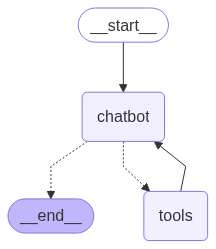

In [40]:
graph_builder.add_edge(START, "chatbot")

# As arestas condicionais e de volta para o chatbot
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")


checkpointer = MemorySaver()
config = {
    "configurable": {
        "model": llm,
        "thread_id": "1"
    }
}
graph = graph_builder.compile(checkpointer=checkpointer)
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### Agent Prompting
Essa é a parte que estava focando. Estava tentando usar "Iterative Refinement Prompting" & "Reasoning and Acting"
Entretanto o próprio agent_dataframe ja faz essas coisas, então apenas usei o prefixo com a estratégia de persona, e o sufixo com informações do dataset.


### Tentando conversar com o agente

In [41]:
estado = graph.invoke({"messages": [HumanMessage(content="Verifique a existencia de nulos no dataset e lide com eles")]}, config)



> Entering new AgentExecutor chain...
Thought: Para verificar a existência de nulos no dataset e lidar com eles, primeiro preciso entender a estrutura dos dados e identificar se há valores ausentes. Vou começar verificando a presença de valores nulos no dataframe `df`.

Action: python_repl_ast
Action Input: df.isnull().sum()timestamp       0
313344       1274
313349       1320
313438       1245
313450       1377
             ... 
313184       1343
313190       1290
313197       1353
313204       1338
313339       1282
Length: 359, dtype: int64O dataframe `df` contém valores nulos em várias colunas, exceto na coluna 'timestamp'. A quantidade de valores nulos varia entre as colunas. Para lidar com esses valores nulos, preciso escolher um método de imputação adequado para séries temporais.

Considerando que o dataset representa uma série temporal e que as colunas numéricas têm missing data, vou usar uma ferramenta de imputação adequada para séries temporais. A ferramenta `imputacao_stmw

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_16784\2950093071.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_trend'] = df[col].rolling(window=5).mean()
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_16784\2950093071.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_trend'] = df[col].rolling(window=5).mean()
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_16784\2950093071.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

ValueError: Passing extra keyword arguments to IterativeImputer.fit is only supported if enable_metadata_routing=True, which you can set using `sklearn.set_config`. See the User Guide <https://scikit-learn.org/stable/metadata_routing.html> for more details. Extra parameters passed are: {'sample_weight'}

In [13]:
estado["messages"]

[{'input': [HumanMessage(content='Me forneça uma informação interessante sobre o dataset', additional_kwargs={}, response_metadata={})],
  'output': "A coluna '313344' tem uma média de 120.40, um desvio padrão de 76.84 e não possui valores nulos, apresentando uma grande variabilidade nos dados.",
  'intermediate_steps': [(AgentAction(tool='get_column_names', tool_input='None', log='Thought: Para fornecer uma informação interessante sobre o dataset, primeiro preciso entender a estrutura e o conteúdo do dataset. Vou começar obtendo os nomes das colunas.\n\nAction: get_column_names\nAction Input: None'),
    "['timestamp', '313344', '313349', '313438', '313450', '313487', '313493', '313512', '313551', '313552', '317752', '313658', '317814', '317815', '317842', '317843', '317852', '317853', '315804', '317861', '317862', '313772', '317869', '315822', '317870', '315823', '315824', '315826', '315827', '315828', '315825', '315830', '315831', '315833', '315834', '315835', '317884', '317885', '3